# Molecular Spectral Latent Modelling
- Jan Andrzejewski
- Marcel Wilanowicz

In [1]:
import selfies as sf
import pandas as pd
import pyarrow.parquet as pq

In [2]:
%pip install torch torchvision torchaudio

'[C][O][C]'

In [33]:
import random
import matplotlib.pyplot as plt
import glob
import os
import pandas as pd
import selfies as sf
import re
import csv
from collections import Counter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

### Wczytanie i analiza struktury danych

In [3]:
''' Do wstępnej analizy załadowano losową próbkę k=10 plików, 
co odpowiada około 4% całego zbioru. '''

import random, glob, os, pandas as pd


DATA_DIR = "multimodal_spectroscopic_dataset"

# znajdź wszystkie pliki .parquet
paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.parquet")))
print("Znaleziono plików:", len(paths))

# pobierz losową próbkę k=10
k = 2
sample_paths = random.sample(paths, k=k)

# wczytaj je i policz rekordy
dfs = []
rows_total = 0

for p in sample_paths:
    df = pd.read_parquet(p)
    dfs.append(df)
    print(os.path.basename(p), "->", len(df), "wierszy")
    rows_total += len(df)

data = pd.concat(dfs, ignore_index=True)

print("-" * 50)
print(f"Wczytano łącznie: {rows_total:,} rekordów z {k} plików.")
print("Średnia na plik:", rows_total / k)
print("Kolumny:", list(data.columns))

Znaleziono plików: 245
aligned_chunk_9.parquet -> 3222 wierszy
aligned_chunk_12.parquet -> 3249 wierszy
--------------------------------------------------
Wczytano łącznie: 6,471 rekordów z 2 plików.
Średnia na plik: 3235.5
Kolumny: ['smiles', 'hsqc_nmr_peaks', 'hsqc_nmr_spectrum', 'h_nmr_peaks', 'h_nmr_spectra', 'molecular_formula', 'c_nmr_peaks', 'ir_spectra', 'msms_positive_10ev', 'msms_positive_20ev', 'msms_positive_40ev', 'msms_fragments_positive', 'msms_negative_10ev', 'msms_negative_20ev', 'msms_negative_40ev', 'msms_fragments_negative', 'c_nmr_spectra']


W katalogu *multimodal_spectroscopic_dataset* znajduje się 245 plików w formacie .parquet.  
Losowa próbka 10 plików zawiera łącznie 32 441 rekordów (średnio ok. 3 200 rekordów na plik).  
Każdy rekord opisuje jedną cząsteczkę chemiczną i składa się z 17 kolumn:

| Kolumna | Opis |
|--------|------|
| smiles | struktura chemiczna w notacji SMILES |
| hsqc_nmr_peaks | lista pików widma HSQC NMR (pozycje 1H/13C, intensywności) |
| hsqc_nmr_spectrum | pełne widmo HSQC NMR w formie tablicy wartości |
| h_nmr_peaks | lista pików ¹H NMR (częstotliwości, integraly) |
| h_nmr_spectra | pełne widmo ¹H NMR jako wektor intensywności |
| molecular_formula | wzór sumaryczny cząsteczki (np. C19H9F5O4S) |
| c_nmr_peaks | lista pików ¹³C NMR |
| ir_spectra | widmo IR (absorbancja w funkcji liczby falowej) |
| msms_positive_10ev | widmo MS/MS w trybie dodatnim przy energii 10 eV |
| msms_positive_20ev | widmo MS/MS w trybie dodatnim przy energii 20 eV |
| msms_positive_40ev | widmo MS/MS w trybie dodatnim przy energii 40 eV |
| msms_fragments_positive | fragmenty jonów dodatnich z przypisanymi formułami |
| msms_negative_10ev | widmo MS/MS w trybie ujemnym przy energii 10 eV |
| msms_negative_20ev | widmo MS/MS w trybie ujemnym przy energii 20 eV |
| msms_negative_40ev | widmo MS/MS w trybie ujemnym przy energii 40 eV |
| msms_fragments_negative | fragmenty jonów ujemnych z przypisanymi formułami |
| c_nmr_spectra | pełne widmo ¹³C NMR |

### Wyjaśnienie terminologii

SMILES – tekstowa reprezentacja struktury chemicznej (atomy, wiązania, pierścienie zapisane jako ciąg znaków).

Molecular formula (wzór sumaryczny) – zlicza, ile atomów każdego pierwiastka zawiera cząsteczka (np. C15H12BrFN4).

NMR (nuclear magnetic resonance) – technika pozwalająca określić, jakie atomy znajdują się w cząsteczce i w jakim są otoczeniu chemicznym.  
- ¹H NMR – sygnały od protonów (atomów wodoru).  
- ¹³C NMR – sygnały od atomów węgla.  
- HSQC – widmo dwuwymiarowe ¹H–¹³C, które łączy protony z odpowiadającymi im atomami węgla.  
- Pik (peak) – pojedynczy sygnał w widmie.  
- Integral – obszar pod pikiem ¹H NMR; informuje, ile protonów daje dany sygnał.  
- Widmo (spectrum) – lista intensywności sygnału w funkcji częstotliwości (ppm).

IR (infrared spectroscopy) – widmo drgań cząsteczki; różne grupy funkcyjne pochłaniają promieniowanie IR w charakterystycznych miejscach, co pozwala je identyfikować.

MS/MS (tandem mass spectrometry) – technika, która rozbija cząsteczkę na fragmenty i mierzy ich masy.  
- m/z – stosunek masy do ładunku jonu.  
- Tryb dodatni/ujemny – sposób jonizacji (kationy lub aniony).  
- 10/20/40 eV – energia fragmentacji; wyższa energia daje więcej fragmentów.  
- Fragments – lista fragmentów z przypisanymi im formułami.

Każdy z tych typów danych pochodzi z innej techniki pomiarowej i opisuje inną właściwość tej samej cząsteczki. Zestaw zawiera tekstową strukturę, widma 1D, widma 2D, widma masowe oraz widmo IR, więc jest **multimodalny** (zawiera wiele modalności danych naraz).

In [4]:
import re

def count_elements(smiles):
    els = re.findall(r"[A-Z][a-z]?", smiles)
    return len(set(els))

data["n_elements"] = data["smiles"].map(count_elements)
data["is_organic"] = data["smiles"].str.contains("C")
data["smiles_len"] = data["smiles"].str.len()

print("Udział organicznych:", data["is_organic"].mean()*100)
print("Mediana długości SMILES:", data["smiles_len"].median())
print("Mediana liczby pierwiastków:", data["n_elements"].median())

Udział organicznych: 99.52497701501686
Mediana długości SMILES: 39.0
Mediana liczby pierwiastków: 4.0


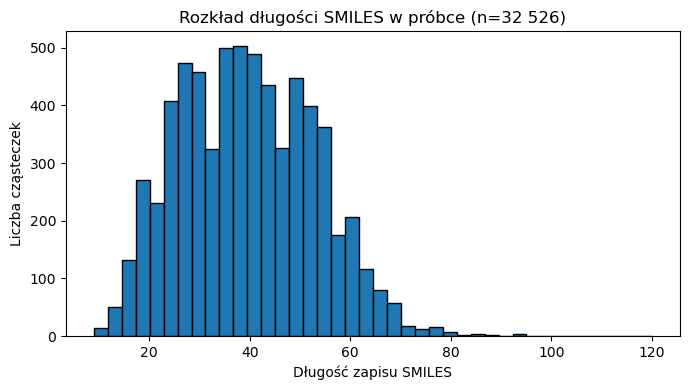

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.hist(data["smiles_len"], bins=40, edgecolor="black")
plt.xlabel("Długość zapisu SMILES")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład długości SMILES w próbce (n=32 526)")
plt.tight_layout()
plt.savefig("smiles_length_hist.png", dpi=150)
plt.show()

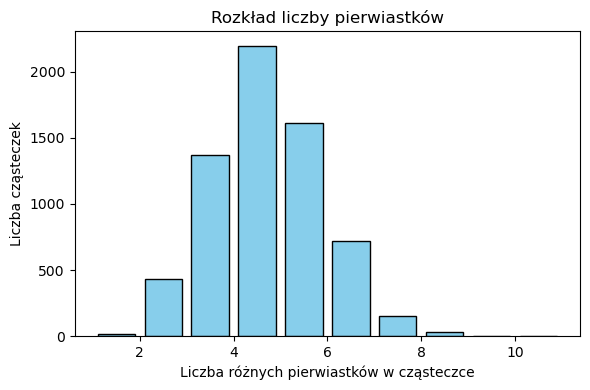

In [6]:
plt.figure(figsize=(6,4))
plt.hist(data["n_elements"].dropna(), bins=range(1,12), rwidth=0.8, color="skyblue", edgecolor="black")
plt.xlabel("Liczba różnych pierwiastków w cząsteczce")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład liczby pierwiastków")
plt.tight_layout()
plt.savefig("num_elements_hist.png", dpi=150)
plt.show()

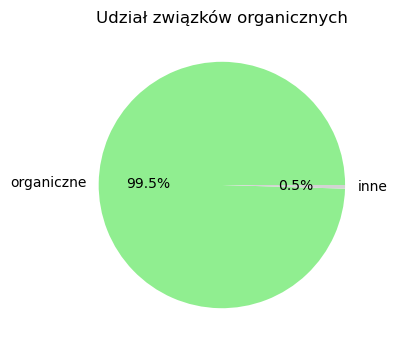

In [7]:
counts = data["is_organic"].value_counts()
plt.figure(figsize=(4,4))
plt.pie(counts, labels=["organiczne","inne"], autopct="%.1f%%", colors=["lightgreen","lightgray"])
plt.title("Udział związków organicznych")
plt.savefig("organic_pie.png", dpi=150)
plt.show()

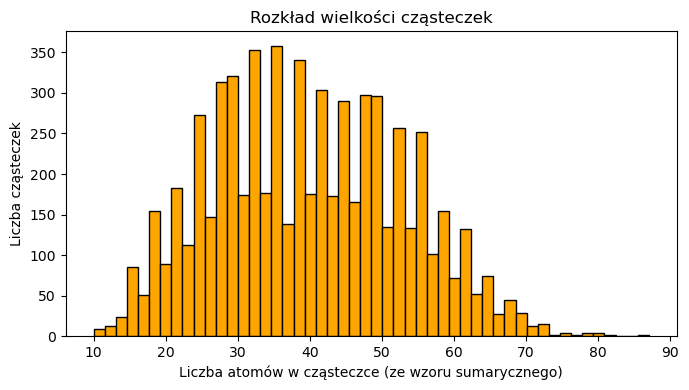

In [8]:
import re

def atom_count(formula):
    nums = re.findall(r"\d+", str(formula))
    return sum(map(int, nums)) if nums else None

data["atom_count"] = data["molecular_formula"].map(atom_count)

plt.figure(figsize=(7,4))
plt.hist(data["atom_count"].dropna(), bins=50, color="orange", edgecolor="black")
plt.xlabel("Liczba atomów w cząsteczce (ze wzoru sumarycznego)")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład wielkości cząsteczek")
plt.tight_layout()
plt.savefig("atom_count_hist.png", dpi=150)
plt.show()

Przykładowy SMILES:

In [9]:
med = data["smiles"].str.len().median()
one = data.iloc[(data["smiles"].str.len() - med).abs().argsort()[:1]][["smiles","molecular_formula"]]
print(one.to_dict(orient="records")[0])

{'smiles': 'COc1ccc(/C(C#N)=C/c2cc(F)c(F)cc2F)cc1OC', 'molecular_formula': 'C17H12F3NO2'}


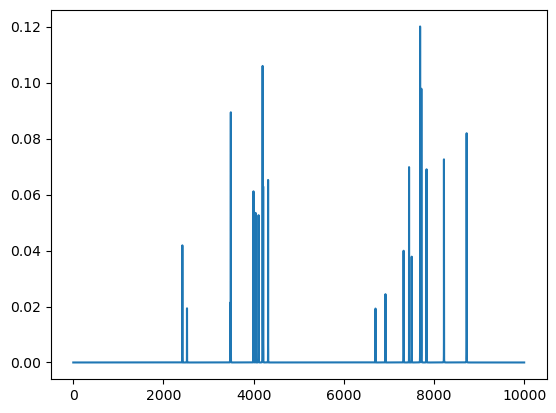

In [10]:
plt.plot(data["c_nmr_spectra"][0])

In [ ]:
df_selfies = pd.DataFrame()
df_selfies['smiles'] = data['smiles']
# TBD: convert SMILES to SELFIES and store in new csv file

### Tokenization

In [20]:
df = data
df['selfies'] = df['smiles'].apply(sf.encoder)
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

In [21]:
all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [PAD, SOS, EOS] + vocab

In [29]:
tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

In [32]:
print(tok2id['[#Branch1]'])
print(id2tok[3])

3
[#Branch1]


### h_nmr peaks

In [23]:
hnmr_peaks = data['h_nmr_peaks']
print(hnmr_peaks[0])

[{'category': 's', 'centroid': 9.937205019608456, 'delta': 9.937205019608456, 'j_values': None, 'nH': 1, 'rangeMax': 9.954441607059994, 'rangeMin': 9.919968432156915}
 {'category': 's', 'centroid': 8.082918073859796, 'delta': 8.082918073859796, 'j_values': None, 'nH': 2, 'rangeMax': 8.100154661311334, 'rangeMin': 8.065681486408257}
 {'category': 'dt', 'centroid': 7.634107766526817, 'delta': 7.634383139180675, 'j_values': '2.2618408203125_7.7646484375_', 'nH': 1, 'rangeMax': 7.66390261443302, 'rangeMin': 7.604986284252448}
 {'category': 't', 'centroid': 7.391251131948668, 'delta': 7.391102708291832, 'j_values': '7.72607421875_', 'nH': 1, 'rangeMax': 7.423757554206565, 'rangeMin': 7.358387956515784}
 {'category': 'dd', 'centroid': 7.327563479744344, 'delta': 7.327370399954181, 'j_values': '1.898193359375_2.634033203125_', 'nH': 1, 'rangeMax': 7.349419236494636, 'rangeMin': 7.305884052394755}
 {'category': 'dt', 'centroid': 6.959142706221009, 'delta': 6.9588169454116695, 'j_values': '2.53

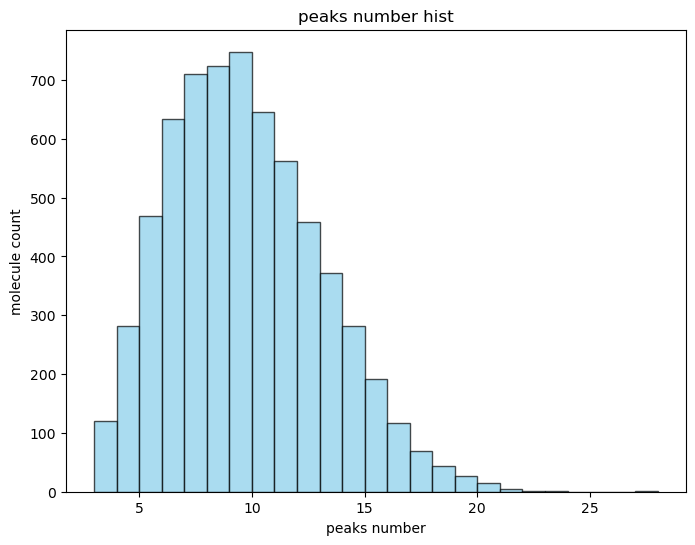

In [22]:
peaks_number = [len(hnmr_peaks[i]) for i in range(len(hnmr_peaks))]

plt.figure(figsize=(8,6))
plt.hist(peaks_number, bins=25, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('peaks number hist')
plt.xlabel('peaks number')
plt.ylabel('molecule count')
plt.show()

In [27]:
n = 12
peaks_less_than = [len(x) for x in hnmr_peaks if len(x) < n]
print(len(peaks_less_than))

4891


In [ ]:
# Funkcja licząca liczbę atomów wodoru w danej cząsteczce na podstawie jej wzoru sumarycznego
def count_h_from_formula(formula):
    # Sprawdzenie, czy to jest string
    if not isinstance(formula, str):
        return 0
    # szukamy fragmentu zaczynającego sie od "H", opcjonalnie z liczbą, np. "H2", "H12", albo samo "H"
    m = re.search(r'H(\d*)', formula)
    
    # Warunek jeśli nie znaleziono
    if m is None: 
        return 0
    # Pobieramy liczbę znajdującą się po H, jeśli nie ma to pusty string
    num_str = m.group(1)

    # Jeśli po H nie ma liczby, to jest jeden atom H
    if num_str == "":
        return 1
    
    # Jeśli liczba po H istnieje, konwertujemy zwracaną wartość do int
    return int(num_str)

In [45]:
# Słownik zliczający ile cząsteczek ma daną liczbę atomów H
# np. {12: 8421, 10: 7900, 8: 6540, 15: 3000, 1: 120}
h_distribution = Counter()

# Licznik wszystkich cząsteczek.
total_molecules = 0 

# Iteracja po wszystkich plikach .parquet
for p in paths: 
    # Wczytujemy tylko kolumnę "molecular_formula"
    df = pd.read_parquet(p, columns=["molecular_formula"])
    # informacja o danym pliku
    # print(os.path.basename(p), "->", len(df), "wierszy") 

    # Iteracja po wzorach sumarycznych w kolumnie "molecular_formula"
    for formula in df["molecular_formula"]:
        # liczenie liczby atomów H we wzorze, np. C15H12N2O2 -> 12
        h_count = count_h_from_formula(formula) 
        # aktualizacja rozkładu o daną liczbę H 
        # np. Jeśli pojawił się H=12 -> inkrementujemy h_distribution[12]
        h_distribution[h_count] += 1
        # zwiększenie licznika wszystkich cząsteczek
        total_molecules += 1

    del df  # zwolnienie pamięci

print("\nŁączna liczba cząsteczek:", total_molecules)
print("Liczba różnych wartości H:", len(h_distribution))

# posortowany rozkład
print("\nRozkład liczby atomów wodoru:")
for h, count in sorted(h_distribution.items()):
    print(f"H = {h:3d} -> {count} cząsteczek")

# najczęstsze wartości H
print("\nNajczęściej występujące liczby atomów wodoru:")
for h, count in h_distribution.most_common(10):
    print(f"H = {h:3d} -> {count} cząsteczek")


Łączna liczba cząsteczek: 794403
Liczba różnych wartości H: 64

Rozkład liczby atomów wodoru:
H =   1 -> 16 cząsteczek
H =   2 -> 41 cząsteczek
H =   3 -> 706 cząsteczek
H =   4 -> 2242 cząsteczek
H =   5 -> 5887 cząsteczek
H =   6 -> 10159 cząsteczek
H =   7 -> 14728 cząsteczek
H =   8 -> 19858 cząsteczek
H =   9 -> 24940 cząsteczek
H =  10 -> 30000 cząsteczek
H =  11 -> 32982 cząsteczek
H =  12 -> 37758 cząsteczek
H =  13 -> 38912 cząsteczek
H =  14 -> 42241 cząsteczek
H =  15 -> 40680 cząsteczek
H =  16 -> 42861 cząsteczek
H =  17 -> 40471 cząsteczek
H =  18 -> 42178 cząsteczek
H =  19 -> 38987 cząsteczek
H =  20 -> 39120 cząsteczek
H =  21 -> 35819 cząsteczek
H =  22 -> 35015 cząsteczek
H =  23 -> 31162 cząsteczek
H =  24 -> 29343 cząsteczek
H =  25 -> 25474 cząsteczek
H =  26 -> 23594 cząsteczek
H =  27 -> 19378 cząsteczek
H =  28 -> 17698 cząsteczek
H =  29 -> 14106 cząsteczek
H =  30 -> 12475 cząsteczek
H =  31 -> 9106 cząsteczek
H =  32 -> 8420 cząsteczek
H =  33 -> 5964 cząst

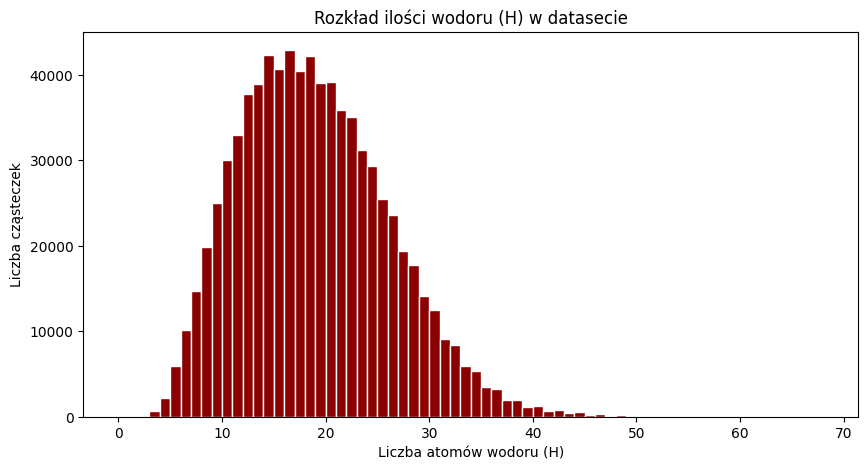

In [51]:
# przekształcenie Counter na listę wartości
# Zamienia słownik rozkładu (wartość -> liczba wystąpień)
# na długą listę wszystkich wartości H powtórzonych tyle razy, 
#  ile w datasetcie wystąpiły
h_values = []
for h_count, freq in h_distribution.items():
    h_values += [h_count] * freq  # np. dla h_count=12, freq=3 dodaje [12, 12, 12]

plt.figure(figsize=(10, 5))
# Dodajemy +2, bo histogram potrzebuje dodatkowej granicy, a range() nie obejmuje swojego końca
plt.hist(h_values, bins=range(0, max(h_values)+2), edgecolor='white', color='darkred')
plt.xlabel("Liczba atomów wodoru (H)")
plt.ylabel("Liczba cząsteczek")
plt.title("Rozkład ilości wodoru (H) w datasecie")
plt.show()

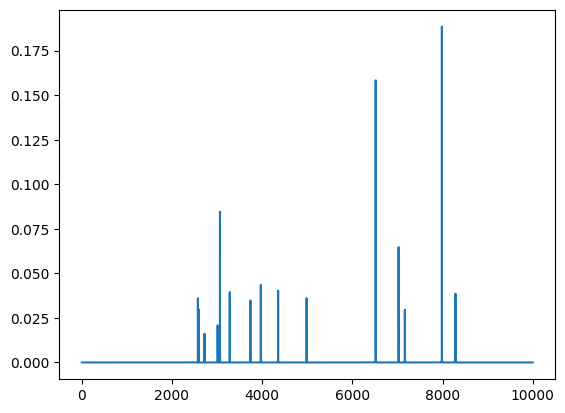

In [58]:
# TBD: Osobny dataset z obrazami spektrów NMR (uzupelnienie do SMILES i SELFIES)
plt.plot(data["c_nmr_spectra"][0])

## 2. Konwersja: SMILES -> SELFIES -> CSV (streamingowo po wszystkich plikach)
### Nowy, lżejszy dataset tekstowy

In [ ]:
# Przykładowa konwersja SMILES -> SELFIES
smiles = list(data['smiles'])

for i in range(10):
    selfie = sf.encoder(smiles[i])
    print(selfie)

[C][C][Branch1][C][C][Branch1][C][C][O][C][=Branch1][C][=O][/C][=C][/C][=C][C][=C][Branch1][#C][N][C][=Branch1][C][=O][C][N][C][C][O][C][C][Ring1][=Branch1][N][=C][Ring1][S]
[C][O][C][=C][C][=C][Branch2][Ring1][Ring1][C][C][=Branch1][Ring1][=N][O][C][=C][C][=C][Branch1][Ring1][O][C][C][=C][Ring1][Branch2][C][=C][Ring2][Ring1][C]
[C][O][C][=Branch1][C][=O][C][=C][C][=C][C][=C][C][Branch1][O][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][C][Ring1][=C][=C][Ring2][Ring1][C]
[C][C][=C][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][NH1][C][=Branch1][C][=O][N][Ring1][N][C][C][C][N][C][C][Ring1][=Branch1]
[C][C][=Branch1][C][=O][N][C][=C][C][=C][Branch1][=Branch1][C][=Branch1][C][=O][O][C][Branch1][C][C][=C][Ring1][#Branch2]
[F][C][=C][C][=C][C][Branch1][#Branch2][N][C][C][C][N][C][C][Ring1][=Branch1][=C][Ring1][=N]
[C][N][C][=N][C][Branch1][S][C][=C][C][=C][Branch1][Ring1][C][#N][C][Branch1][C][F][=C][Ring1][=Branch2][=C][C][Branch1][N][N][C][C][C][C@@H1][Branch1][C][N][C][Ring1]

In [ ]:
###### DON'T RUN THIS CELL UNLESS YOU WANT TO OVERWRITE THE CSV FILE ######
DATA_DIR = "multimodal_spectroscopic_dataset"
OUT_CSV = "smiles_selfies_full.csv"

# znajdź i posortuj pliki .parquet liczbowo po numerze chunku
paths = glob.glob(os.path.join(DATA_DIR, "*.parquet"))
paths = sorted(paths, key=lambda x: int(re.findall(r"(\d+)", x)[-1]))

print("Znaleziono plików:", len(paths))

# otwieramy plik CSV raz, dopisujemy w pętli
with open(OUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(["smiles", "selfies"])  # nagłówek

    for p in paths:
        # wczytujemy tylko kolumnę 'smiles'
        df = pd.read_parquet(p, columns=["smiles"])
        print(os.path.basename(p), "->", len(df), "wierszy")

        for smi in df["smiles"]:
            if not isinstance(smi, str):
                continue
            try:
                # strict=False = nie wywali się na dziwnych SMILESach
                selfie = sf.encoder(smi, strict=False)
            except Exception:
                selfie = ""  # albo np. "[INVALID]"

            writer.writerow([smi, selfie])

        del df

print("Zapisano pełny plik CSV:", OUT_CSV)

Znaleziono plików: 245
aligned_chunk_0.parquet -> 3235 wierszy
aligned_chunk_1.parquet -> 3273 wierszy
aligned_chunk_2.parquet -> 3129 wierszy
aligned_chunk_3.parquet -> 3226 wierszy
aligned_chunk_4.parquet -> 3280 wierszy
aligned_chunk_5.parquet -> 3292 wierszy
aligned_chunk_6.parquet -> 3233 wierszy
aligned_chunk_7.parquet -> 3211 wierszy
aligned_chunk_8.parquet -> 3225 wierszy
aligned_chunk_9.parquet -> 3222 wierszy
aligned_chunk_10.parquet -> 3244 wierszy
aligned_chunk_11.parquet -> 3270 wierszy
aligned_chunk_12.parquet -> 3249 wierszy
aligned_chunk_13.parquet -> 3243 wierszy
aligned_chunk_14.parquet -> 3239 wierszy
aligned_chunk_15.parquet -> 3204 wierszy
aligned_chunk_16.parquet -> 3276 wierszy
aligned_chunk_17.parquet -> 3378 wierszy
aligned_chunk_18.parquet -> 3281 wierszy
aligned_chunk_19.parquet -> 3262 wierszy
aligned_chunk_20.parquet -> 3254 wierszy
aligned_chunk_21.parquet -> 3241 wierszy
aligned_chunk_22.parquet -> 3240 wierszy
aligned_chunk_23.parquet -> 3296 wierszy
ali

In [ ]:
# Test pliku CSV
pd.set_option('display.max_colwidth', None)
df = pd.read_csv("smiles_selfies_full.csv")
df.head()      # pierwsze 5 wierszy

,smiles,selfies
0,O=S(O)c1cc2c(cc1F)OC(c1ccc(F)cc1F)(c1ccc(F)cc1F)O2,[O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]
1,CN(C)Cc1cccc(C2Nc3cccc4c(=O)[nH]nc(c34)C2c2ccccc2)c1,[C][N][Branch1][C][C][C][C][=C][C][=C][C][Branch2][Ring1][P][C][N][C][=C][C][=C][C][C][=Branch1][C][=O][NH1][N][=C][Branch1][=Branch1][C][Ring1][O][=Ring1][#Branch1][C][Ring1][=C][C][=C][C][=C][C][=C][Ring1][=Branch1][=C][Ring2][Ring1][#Branch2]
2,O=C(N[C@@H](CO)c1nc2cc(Cl)ccc2[nH]1)c1ccc(C(=O)N2CC=CC2)c(Br)c1,[O][=C][Branch2][Ring1][#Branch1][N][C@@H1][Branch1][Ring1][C][O][C][=N][C][=C][C][Branch1][C][Cl][=C][C][=C][Ring1][#Branch1][NH1][Ring1][#Branch2][C][=C][C][=C][Branch1][N][C][=Branch1][C][=O][N][C][C][=C][C][Ring1][Branch1][C][Branch1][C][Br][=C][Ring1][=C]
3,O=C(Cn1cc(I)cn1)N1CCCc2c1cnn2-c1ccc(F)cc1,[O][=C][Branch1][N][C][N][C][=C][Branch1][C][I][C][=N][Ring1][=Branch1][N][C][C][C][C][=C][Ring1][=Branch1][C][=N][N][Ring1][Branch1][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1]
4,Cc1ccc(-c2ccnc(Cl)c2)n1CC(=O)OCc1ccccc1,[C][C][=C][C][=C][Branch1][N][C][=C][C][=N][C][Branch1][C][Cl][=C][Ring1][#Branch1][N][Ring1][N][C][C][=Branch1][C][=O][O][C][C][=C][C][=C][C][=C][Ring1][=Branch1]


## 3. Tokenizacja SELFIES

Specjalne tokeny używane w modelu sekwencyjnym:

| Token     | Znaczenie                     |
|-----------|-------------------------------|
| &lt;bos&gt; | beginning of sequence         |
| &lt;eos&gt; | end of sequence               |
| &lt;pad&gt; | padding (wyrównanie długości) |
| &lt;unk&gt; | unknown token                 |

Przykładowe tokeny SELFIES:

[’[C]’, ‘[C]’, ‘[O]’, ‘[Branch1_1]’, ‘[C]’]

Po dodaniu tokenów specjalnych i padding'u do wyrównania długości:


| Token        | Indeks |
|--------------|---------|
| &lt;bos&gt;        | 1       |
| [C]          | 10      |
| [C]          | 10      |
| [O]          | 23      |
| [Branch1_1]  | 41      |
| [C]          | 10      |
| &lt;eos&gt;        | 2       |
| &lt;pad&gt;        | 0       |
| &lt;pad&gt;        | 0       |
| ...          | ...       |

In [60]:
def tokenize_selfies(selfies_str):
    ''' Zwraca listę tokenów SELFIES (rozcina string na pojedyncze tokeny), 
    np. '[C][O][Branch1_1]' -> ['[C]', '[O]', '[Branch1_1]']
    '''
    return list(sf.split_selfies(selfies_str))

def build_vocabulary(selfies_list):
    ''' Tworzy słowniki "stoi" oraz "itos" z listy stringów 
    (numeruje wszystkie tokeny, tak żeby model mógł pracować na liczbach)
        
    Terminologia:
    stoi: token -> index  (string-to-index)
    itos: index -> token (index-to-string)
    '''
    # Zliczanie wystąpień tokenów w datasetcie
    token_counter = Counter()

    # Iteracja po wszystkich SELFIES w liście
    for selfies_string in selfies_list:
        # uzyskanie tokenów z SELFIES
        tokens = tokenize_selfies(selfies_string)
        # aktualizacja licznika tokenów
        token_counter.update(tokens)

    # Utworzenie zbioru specjalnych tokenów do trenowania modelu sekwencyjnego
    sequence_tokens = ["<pad>", "<bos>", "<eos>", "<unk>"]
        
    ## Budowa listy index -> token
    itos = [] # index-to-string

    # Dodanie specjalnych tokenów na początek
    for t in sequence_tokens:
        itos.append(t)

    # Dodanie pozostałych tokenów posortowane od najczęstszych
    for token, _ in token_counter.most_common():
        itos.append(token)

    ## Budowa listy token -> index (mapowanie)
    stoi = {} # string-to-index
    idx = 0
    for token in itos:
        stoi[token] = idx
        idx += 1

    return stoi, itos

# Zamiana SELFIES na listę indeksów
def selfies_to_indices(selfies_string, stoi, max_length=100):
    '''Ta funkcja bierze pojedynczy SELFIES i zwraca listę liczb, 
    które będzie można wysłać do modelu GRU-VAE. '''
    
    # Tokenizacja i dodanie znaczników (model musi wiedzieć gdzie się zaczyna,
    # a gdzie się kończy sekwencja
    tokens = tokenize_selfies(selfies_string)
    sequence = ["<bos>"] + tokens + ["<eos>"]
    
    # Jeśli sekwencja jest zbyt długa -> skracamy.
    if len(sequence) > max_length:
        sequence = sequence[:max_length]

    # Konwersja tokenów na liczby (indeksy)
    indices = []
    for token in sequence:
        if token in stoi:
            indices.append(stoi[token])
        else:
            indices.append(stoi["<unk>"])

    # Jeśli padding za krótki
    if len(indices) < max_length:
        # Wyrownanie do max_length
        indices += [stoi["<pad>"]] * (max_length - len(indices)) 
        
    return indices

In [27]:
# Pobranie kolumny 'selfies' jako lista (lista tysięcy SELFIES stringów)
selfies_list = df["selfies"].tolist()

# bierzemy pierwszy SELFIES z kolumny
single_selfies = df["selfies"].iloc[0]
print("SELFIES:", single_selfies)

SELFIES: [O][=S][Branch1][C][O][C][=C][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][F][O][C][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][Branch1][=N][C][=C][C][=C][Branch1][C][F][C][=C][Ring1][#Branch1][F][O][Ring2][Ring1][Branch2]


In [59]:
# Budowa słowników stoi i itos
stoi, itos = build_vocabulary([single_selfies])
print("string-to-index:", stoi)
print("Vocab size:", len(stoi))

print("\nitos: ", itos)
print("\nstoi: ", stoi)

string-to-index: {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3, '[C]': 4, '[=C]': 5, '[Branch1]': 6, '[F]': 7, '[O]': 8, '[Ring1]': 9, '[=Branch1]': 10, '[=N]': 11, '[#Branch1]': 12, '[=S]': 13, '[Ring2]': 14, '[Branch2]': 15}
Vocab size: 16

itos:  ['<pad>', '<bos>', '<eos>', '<unk>', '[C]', '[=C]', '[Branch1]', '[F]', '[O]', '[Ring1]', '[=Branch1]', '[=N]', '[#Branch1]', '[=S]', '[Ring2]', '[Branch2]']

stoi:  {'<pad>': 0, '<bos>': 1, '<eos>': 2, '<unk>': 3, '[C]': 4, '[=C]': 5, '[Branch1]': 6, '[F]': 7, '[O]': 8, '[Ring1]': 9, '[=Branch1]': 10, '[=N]': 11, '[#Branch1]': 12, '[=S]': 13, '[Ring2]': 14, '[Branch2]': 15}


In [29]:
indices = selfies_to_indices(single_selfies, stoi, max_length=80)
tensor = torch.tensor([indices], dtype=torch.long)

## 4. Enkoder i dekoder w VAE za pomocą GRU
### SELFIES -> [GRU Encoder] -> z -> [GRU Decoder] -> SELFIES

### Preprocessing

In [ ]:
# Zamiana batcha z SELFIES na tensor indeksów
def selfies_to_tensor(selfies_batch, stoi, max_length=100):
    # Utwórz pustą listę na sekwencje indeksów (każda będzie miała długość max_length)
    batch_indices = []
    
    # Przetwarzanie każdej sekwencji SELFIES w batchu
    for selfie in selfies_batch:
        # Zamiana pojedynczego SELFIES na listę indeksów (z <bos>, <eos>, paddingiem itd.)
        idx_seq = selfies_to_indices(selfie, stoi, max_length)
        
        # Dodanie sekwencji do batcha
        batch_indices.append(idx_seq)

    # Konwersja listy list na tensor typu long (wymagany przez modele PyTorch)
    return torch.tensor(batch_indices, dtype=torch.long)